# Modeling of the thickness of the sensor

In this notebook we will re-use the experiment done at ID18 and previously calibrated and model in 3D the detector.

This detector is a Pilatus 1M with a 450µm thick silicon sensor. Let's first have a look at the absorption coefficients of this sensor material: https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z14.html

First we retieve the results of the previous step, then calculate the absorption efficiency:

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy
import fabio, pyFAI
import json
with open("id28.json") as f:
    calib = json.load(f)

thickness = 450e-6
wavelength = calib["wavelength"]
dist = calib["param"][calib['param_names'].index("dist")]
poni1 = calib["param"][calib['param_names'].index("poni1")]
poni2 = calib["param"][calib['param_names'].index("poni2")]
energy = pyFAI.units.hc/(wavelength*1e10)
print("wavelength: %.3em,\t dist: %.3em,\t poni1: %.3em,\t poni2: %.3em,\t energy: %.3fkeV" % 
      (wavelength, dist, poni1, poni2, energy))


wavelength: 6.968e-11m,	 dist: 2.845e-01m,	 poni1: 8.865e-02m,	 poni2: 8.931e-02m,	 energy: 17.793keV


## Absorption coeficient at 17.8 keV

In [3]:
# density from https://en.wikipedia.org/wiki/Silicon
rho = 2.3290 # g/cm^3

#Absorption from https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z14.html
# Nota: enegies are in MeV !
Si_abs = """
   2.00000E-03  2.777E+03  2.669E+03 
   3.00000E-03  9.784E+02  9.516E+02 
   4.00000E-03  4.529E+02  4.427E+02 
   5.00000E-03  2.450E+02  2.400E+02 
   6.00000E-03  1.470E+02  1.439E+02 
   8.00000E-03  6.468E+01  6.313E+01 
   1.00000E-02  3.389E+01  3.289E+01 
   1.50000E-02  1.034E+01  9.794E+00 
   2.00000E-02  4.464E+00  4.076E+00 
   3.00000E-02  1.436E+00  1.164E+00 
   4.00000E-02  7.012E-01  4.782E-01 
   5.00000E-02  4.385E-01  2.430E-01 
   6.00000E-02  3.207E-01  1.434E-01 
   8.00000E-02  2.228E-01  6.896E-02 
   1.00000E-01  1.835E-01  4.513E-02 
   1.50000E-01  1.448E-01  3.086E-02 
   2.00000E-01  1.275E-01  2.905E-02 
   3.00000E-01  1.082E-01  2.932E-02 
   4.00000E-01  9.614E-02  2.968E-02 
   5.00000E-01  8.748E-02  2.971E-02 
   6.00000E-01  8.077E-02  2.951E-02 
   8.00000E-01  7.082E-02  2.875E-02 
   1.00000E+00  6.361E-02  2.778E-02 
   1.25000E+00  5.688E-02  2.652E-02 
   1.50000E+00  5.183E-02  2.535E-02 
   2.00000E+00  4.480E-02  2.345E-02 
   3.00000E+00  3.678E-02  2.101E-02 
   4.00000E+00  3.240E-02  1.963E-02 
   5.00000E+00  2.967E-02  1.878E-02 
   6.00000E+00  2.788E-02  1.827E-02 
   8.00000E+00  2.574E-02  1.773E-02 
   1.00000E+01  2.462E-02  1.753E-02 
   1.50000E+01  2.352E-02  1.746E-02 
   2.00000E+01  2.338E-02  1.757E-02 """
data = numpy.array([[float(i) for i in line.split()] for line in Si_abs.split("\n") if line])
energy_tab, mu_over_rho, mu_en_over_rho = data.T
abs_18 = numpy.interp(energy, energy_tab*1e3, mu_en_over_rho) 
mu = abs_18*rho*1e+2
eff = 1.0-numpy.exp(-mu*thickness)

print("µ = %f m^-1 hence absorption efficiency for 450µm: %.1f %%"%(mu, eff*100))


µ = 1537.024385 m^-1 hence absorption efficiency for 450µm: 49.9 %


<IPython.core.display.Javascript object>


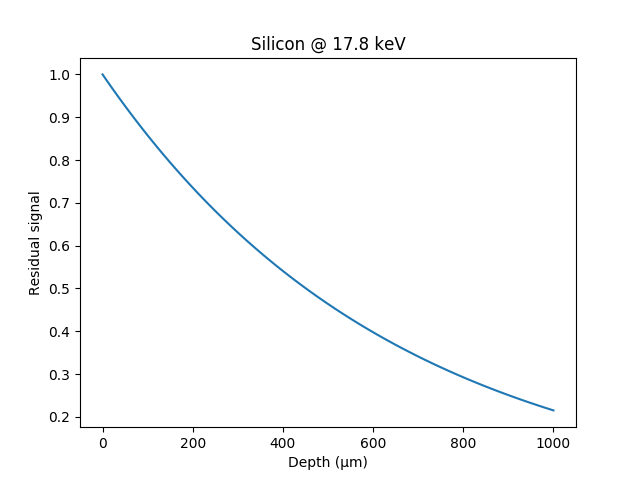

Text(0.5,1,'Silicon @ 17.8 keV')

In [7]:
depth = numpy.linspace(0, 1000, 100)
res = numpy.exp(-mu*depth*1e-6)
fig, ax = subplots()
ax.plot(depth, res, "-")
ax.set_xlabel("Depth (µm)")
ax.set_ylabel("Residual signal")
ax.set_title("Silicon @ 17.8 keV")


This is consistent with:
http://henke.lbl.gov/optical_constants/filter2.html

Now we can model the detector

## Modeling of the detector:

The detector is seen as a 2D array of voxel. Let vox, voy and voz be the dimention of the detector in the three dimentions.



In [12]:
detector= pyFAI.detector_factory(calib["detector"])
print(detector)

vox = detector.pixel2 # this is not a typo
voy = detector.pixel1 # x <--> axis 2
voz = thickness

print(vox, voy, voz)

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
0.000172 0.000172 0.00045


The intensity grabbed in this voxel is the triple integral of the absorbed signal coming from this pixel or from the neighboring ones.

There are 3 ways to perform this intergral:
* Volumetric analytic integral. Looks feasible with a change of variable in the depth
* Slice per slice, the remaining intensity depand on the incidence angle + pixel splitting between neighbooring pixels
* raytracing: the decay can be solved analytically for each ray, one has to throw many ray to average out the signal.

For sake of simplicity, this integral will be calculated numerically using this raytracing algorithm.
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.3443&rep=rep1&type=pdf

Knowing the input position for a X-ray on the detector and its propagation vector, this algorithm allows us to calculate  the length of the path in all voxel it crosses in a fairly efficient way.

To speed up the calculation, we will use a few tricks:
* One ray never crosses more than 16 pixels, which is reasonable considering the incidance angle 
* we use numba to speed-up the calculation of loops in python
* We will allocate the needed memory by chuncks of 1 million elements


In [124]:
from numba import jit 

BLOCK_SIZE = 1<<20 # 1 milion
BUFFER_SIZE = 16 
BIG = numpy.finfo(numpy.float32).max

mask = numpy.load("mask.npy").astype(numpy.int8)
from scipy.sparse import csr_matrix, csc_matrix, linalg

In [76]:
@jit
def calc_one_ray(entx, enty, 
                 kx, ky, kz,
                 vox, voy, voz):
    """For a ray, entering at position (entx, enty), with a propagation vector (kx, ky,kz),
    calculate the length spent in every voxel where energy is deposited from a bunch of photons comming in the detector 
    at a given position and and how much energy they deposit in each voxel. 
    
    Direct implementation of http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.3443&rep=rep1&type=pdf
    
    :param entx, enty: coordinate of the entry point in meter (2 components, x,y)
    :param kx, ky, kz: vector with the direction of the photon (3 components, x,y,z)
    :param vox, voy, voz: size of the voxel in meter (3 components, x,y,z)
    :return: coordinates voxels in x, y and length crossed when leaving the associated voxel
    """
    array_x = numpy.empty(BUFFER_SIZE, dtype=numpy.int32)
    array_x[:] = -1
    array_y = numpy.empty(BUFFER_SIZE, dtype=numpy.int32)
    array_y[:] = -1
    array_len = numpy.empty(BUFFER_SIZE, dtype=numpy.float32)
    
    #normalize the input propagation vector
    n = numpy.sqrt(kx*kx + ky*ky + kz*kz)
    kx /= n
    ky /= n
    kz /= n
    
    assert kz>0
    step_X = -1 if kx<0.0 else 1
    step_Y = -1 if ky<0.0 else 1
    
    assert vox>0
    assert voy>0
    assert voz>0
        
    X = int(entx//vox)
    Y = int(enty//voy)
    
    if kx>0.0:
        t_max_x = ((entx//vox+1)*(vox)-entx)/ kx
    elif kx<0.0:
        t_max_x = ((entx//vox)*(vox)-entx)/ kx
    else:
        t_max_x = BIG

    if ky>0.0:
        t_max_y = ((enty//voy+1)*(voy)-enty)/ ky
    elif ky<0.0:
        t_max_y = ((enty//voy)*(voy)-enty)/ ky
    else:
        t_max_y = BIG
    
    #Only one case for z as the ray is travelling in one direction only
    t_max_z = voz / kz
       
    t_delta_x = abs(vox/kx) if kx!=0 else BIG
    t_delta_y = abs(voy/ky) if ky!=0 else BIG
    t_delta_z = voz/kz
    
    finished = False
    last_id = 0
    array_x[last_id] = X
    array_y[last_id] = Y
    
    while not finished:
        if t_max_x < t_max_y:
            if t_max_x < t_max_z:
                array_len[last_id] = t_max_x
                last_id+=1
                X += step_X
                array_x[last_id] = X
                array_y[last_id] = Y
                t_max_x += t_delta_x
            else:
                array_len[last_id] = t_max_z
                finished = True
        else:
            if t_max_y < t_max_z:
                array_len[last_id] = t_max_y
                last_id+=1
                Y += step_Y
                array_x[last_id] = X
                array_y[last_id] = Y                
                t_max_y += t_delta_y
            else:
                array_len[last_id] = t_max_z
                finished = True
        if last_id>=array_len.size-1:
            print("resize arrays")
            old_size = len(array_len)
            new_size = (old_size//BUFFER_SIZE+1)*BUFFER_SIZE
            new_array_x = numpy.empty(new_size, dtype=numpy.int32)
            new_array_x[:] = -1
            new_array_y = numpy.empty(new_size, dtype=numpy.int32)
            new_array_y[:] = -1
            new_array_len = numpy.empty(new_size, dtype=numpy.float32)
            new_array_x[:old_size] = array_x
            new_array_y[:old_size] = array_y
            new_array_len[:old_size] = array_len
            array_x = new_array_x
            array_y = new_array_y
            array_len = new_array_len
    return array_x[:last_id], array_y[:last_id], array_len[:last_id]

print(calc_one_ray(0.0,0.0, 1,1,1, 172e-6, 172e-6, 450e-6))
import random
%timeit calc_one_ray(10+random.random(),11+random.random(),\
                     random.random()-0.5,random.random()-0.5,0.5+random.random(), \
                     vox, voy, voz)
%timeit calc_one_ray.py_func(10+random.random(),11+random.random(),\
                     random.random()-0.5,random.random()-0.5,0.5+random.random(), \
                     vox, voy, voz)

(array([0, 0, 1, 1], dtype=int32), array([0, 1, 1, 2], dtype=int32), array([ 0.00029791,  0.00029791,  0.00059583,  0.00059583], dtype=float32))
The slowest run took 7.08 times longer than the fastest. This could mean that an intermediate result is being cached.
5.07 µs ± 5.21 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.21 µs ± 7.43 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Now that we are able to perform raytracing for any ray comming in the detector, we can calculate the contribution to the neighboring pixels, using the absorption law (the length travelled is already known). 
To average-out the signal, we will sample a few dozens of rays per pixel to get an approximatation of the volumic integrale. 

Now we need to store the results so that this transformation can be represented as a sparse matrix multiplication:

b = M.a

Where b is the recorded image (blurred) and a is the "perfect" signal. 
M being the sparse matrix where every pixel of a gives a limited number of contribution to b.

Each pixel in *b* is represented by one line in *M* and we store the indices of *a* of interest with the coefficients of the matrix.
So if a pixel i,j contributes to (i,j), (i+1,j), (i+1,j+1), there are only 3 elements in the line. 
This is advantagous for storage.

We will use the CSR sparse matrix representation:
https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29
where there are 3 arrays:
* data: containing the actual non zero values
* indices: for a given line, it contains the column number of the assocated data (at the same indice)
* idptr: this array contains the index of the start of every line.


In [109]:
from numba import jitclass, int8, int32, int64, float32, float64
spec = [("vox",float64),("voy",float64),("voz",float64),("mu",float64),
        ("dist",float64),("poni1",float64),("poni2",float64),
        ("width", int64),("height", int64),("mask", int8[:,:]),
        ("sampled", int64), ("data", float32[:]),("indices", int32[:]),("idptr", int32[:]),
       ]
@jitclass(spec)
class ThickDetector(object):
    "Calculate the point spread function as function of the geometry of the experiment"
    
    def __init__(self, vox, voy, thickness, mask, mu, 
                 dist, poni1, poni2):
        """Constructor of the class:
        
        :param vox, voy: detector pixel size in the plane
        :param thickness: thickness of the sensor in meters
        :param mask: 
        :param mu: absorption coefficient of the sensor material
        :param dist: sample detector distance as defined in the geometry-file
        :param poni1, poni2: coordinates of the PONI as defined in the geometry 
        """
        self.vox = vox
        self.voy = voy
        self.voz = thickness
        self.mu = mu
        self.dist=dist
        self.poni1 = poni1
        self.poni2 = poni2
        self.width = mask.shape[-1]
        self.height = mask.shape[0]
        self.mask = mask
        self.sampled = 0
        self.data = numpy.zeros(BLOCK_SIZE, dtype=numpy.float32)
        self.indices = numpy.zeros(BLOCK_SIZE,dtype=numpy.int32)
        self.idptr = numpy.zeros(self.width*self.height+1, dtype=numpy.int32)
        
    def calc_one_ray(self, entx, enty):
        """For a ray, entering at position (entx, enty), with a propagation vector (kx, ky,kz),
        calculate the length spent in every voxel where energy is deposited from a bunch of photons comming in the detector 
        at a given position and and how much energy they deposit in each voxel. 

        Direct implementation of http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.3443&rep=rep1&type=pdf

        :param entx, enty: coordinate of the entry point in meter (2 components, x,y)
        :return: coordinates voxels in x, y and length crossed when leaving the associated voxel
        """
        array_x = numpy.empty(BUFFER_SIZE, dtype=numpy.int32)
        array_x[:] = -1
        array_y = numpy.empty(BUFFER_SIZE, dtype=numpy.int32)
        array_y[:] = -1
        array_len = numpy.empty(BUFFER_SIZE, dtype=numpy.float32)

        #normalize the input propagation vector
        kx = entx - self.poni2
        ky = enty - self.poni1
        kz = self.dist
        n = numpy.sqrt(kx*kx + ky*ky + kz*kz)
        kx /= n
        ky /= n
        kz /= n

        step_X = -1 if kx<0.0 else 1
        step_Y = -1 if ky<0.0 else 1

        X = int(entx/self.vox)
        Y = int(enty/self.voy)

        if kx>0.0:
            t_max_x = ((entx//self.vox+1)*(self.vox)-entx)/ kx
        elif kx<0.0:
            t_max_x = ((entx//self.vox)*(self.vox)-entx)/ kx
        else:
            t_max_x = BIG

        if ky>0.0:
            t_max_y = ((enty//self.voy+1)*(self.voy)-enty)/ ky
        elif ky<0.0:
            t_max_y = ((enty//self.voy)*(self.voy)-enty)/ ky
        else:
            t_max_y = BIG

        #Only one case for z as the ray is travelling in one direction only
        t_max_z = self.voz / kz

        t_delta_x = abs(self.vox/kx) if kx!=0 else BIG
        t_delta_y = abs(self.voy/ky) if ky!=0 else BIG
        t_delta_z = self.voz/kz

        finished = False
        last_id = 0
        array_x[last_id] = X
        array_y[last_id] = Y

        while not finished:
            if t_max_x < t_max_y:
                if t_max_x < t_max_z:
                    array_len[last_id] = t_max_x
                    last_id+=1
                    X += step_X
                    array_x[last_id] = X
                    array_y[last_id] = Y
                    t_max_x += t_delta_x
                else:
                    array_len[last_id] = t_max_z
                    last_id+=1
                    finished = True
            else:
                if t_max_y < t_max_z:
                    array_len[last_id] = t_max_y
                    last_id+=1
                    Y += step_Y
                    array_x[last_id] = X
                    array_y[last_id] = Y                
                    t_max_y += t_delta_y
                else:
                    array_len[last_id] = t_max_z
                    last_id+=1
                    finished = True
            if last_id>=array_len.size-1:
                print("resize arrays")
                old_size = len(array_len)
                new_size = (old_size//BUFFER_SIZE+1)*BUFFER_SIZE
                new_array_x = numpy.empty(new_size, dtype=numpy.int32)
                new_array_x[:] = -1
                new_array_y = numpy.empty(new_size, dtype=numpy.int32)
                new_array_y[:] = -1
                new_array_len = numpy.empty(new_size, dtype=numpy.float32)
                new_array_x[:old_size] = array_x
                new_array_y[:old_size] = array_y
                new_array_len[:old_size] = array_len
                array_x = new_array_x
                array_y = new_array_y
                array_len = new_array_len
        return array_x[:last_id], array_y[:last_id], array_len[:last_id]

    def one_pixel(self, row, col, sample):
        """calculate the contribution of one pixel to the sparse matrix and populate it.

        :param row: row index of the pixel of interest
        :param col: column index of the pixel of interest
        :param sample: Oversampling rate, 10 will thow 10x10 ray per pixel

        :return: the extra number of pixel allocated
        """
        if self.mask[row, col]:
            return (numpy.empty(0, dtype=numpy.int32),
                    numpy.empty(0, dtype=numpy.float32))

        counter = 0
        tmp_size = 0
        last_buffer_size = BUFFER_SIZE
        tmp_idx = numpy.empty(last_buffer_size, dtype=numpy.int32)
        tmp_idx[:] = -1
        tmp_coef = numpy.zeros(last_buffer_size, dtype=numpy.float32)

        pos = row * self.width + col
        start = self.idptr[pos]
        for i in range(sample):
            posx = (col+1.0*i/sample)*vox
            for j in range(sample):
                posy = (row+1.0*j/sample)*voy
                array_x, array_y, array_len = self.calc_one_ray(posx, posy)

                rem = 1.0
                for i in range(array_x.size):
                    x = array_x[i]
                    y = array_y[i]
                    l = array_len[i]
                    if (x<0) or (y<0) or (y>=self.height) or (x>=self.width):
                        break
                    elif (self.mask[y, x]):
                        continue
                    idx = x + y*self.width
                    dos = numpy.exp(-self.mu*l)
                    value = rem - dos
                    rem = dos
                    for j in range(last_buffer_size):
                        if tmp_size >= last_buffer_size:
                            #Increase buffer size
                            new_buffer_size = last_buffer_size + BUFFER_SIZE
                            new_idx = numpy.empty(new_buffer_size, dtype=numpy.int32)
                            new_coef = numpy.zeros(new_buffer_size, dtype=numpy.float32)
                            new_idx[:last_buffer_size] = tmp_idx
                            new_idx[last_buffer_size:] = -1
                            new_coef[:last_buffer_size] = tmp_coef
                            last_buffer_size = new_buffer_size
                            tmp_idx = new_idx
                            tmp_coef = new_coef

                        if tmp_idx[j] == idx:
                            tmp_coef[j] += value
                            break
                        elif tmp_idx[j] < 0:
                            tmp_idx[j] = idx
                            tmp_coef[j] = value
                            tmp_size +=1
                            break     
        return tmp_idx[:tmp_size], tmp_coef[:tmp_size]

    def calc_csr(self, sample):
        """Calculate the CSR matrix for the whole image
        :param sample: Oversampling factor
        :return: CSR matrix
        """
        size = self.width * self.height
        allocated_size = BLOCK_SIZE
        idptr = numpy.zeros(size+1, dtype=numpy.int32) 
        indices = numpy.zeros(allocated_size, dtype=numpy.int32)
        data = numpy.zeros(allocated_size, dtype=numpy.float32)
        self.sampled = sample*sample
        pos = 0
        start = 0
        for row in range(self.height):
            for col in range(self.width):    
                line_idx, line_coef = self.one_pixel(row, col, sample)
                line_size = line_idx.size
                if line_size == 0:
                    new_size = 0
                    pos+=1
                    idptr[pos] = start
                    continue

                stop = start + line_size
                
                if stop >= allocated_size:
                    new_buffer_size = allocated_size +  BLOCK_SIZE
                    new_idx = numpy.zeros(new_buffer_size, dtype=numpy.int32)
                    new_coef = numpy.zeros(new_buffer_size, dtype=numpy.float32)
                    new_idx[:allocated_size] = indices
                    new_coef[:allocated_size] = data
                    allocated_size = new_buffer_size
                    indices = new_idx
                    data = new_coef

                indices[start:stop] = line_idx
                data[start:stop] = line_coef
                pos+=1
                idptr[pos] = stop
                start = stop
    
        last = idptr[-1]
        self.data = data
        self.indices = indices
        self.idptr = idptr
        return (self.data[:last]/self.sampled, indices[:last], idptr)


In [101]:
thick = ThickDetector(vox,voy, thickness=thickness, mu=mu, dist=dist, poni1=poni1, poni2=poni2, mask=mask)
%time thick.calc_csr(1)

CPU times: user 55.3 s, sys: 1.25 s, total: 56.6 s
Wall time: 54.5 s


(array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
 array([      2,       2,       4, ..., 1023180, 1023181, 1023182], dtype=int32),
 array([      0,       0,       0, ..., 1902581, 1902582, 1902583], dtype=int32))

In [121]:
thick = ThickDetector(vox,voy, thickness=thickness, mu=mu, dist=dist, poni1=poni1, poni2=poni2, mask=mask)
%time pre_csr = thick.calc_csr(16)

CPU times: user 1min 28s, sys: 284 ms, total: 1min 29s
Wall time: 1min 28s


## Validation of the CSR matrix obtained:

For this we will build a simple 2D image with one pixel in a regular grid and calculate the effect of the transformation calculated previously on it. 

<IPython.core.display.Javascript object>


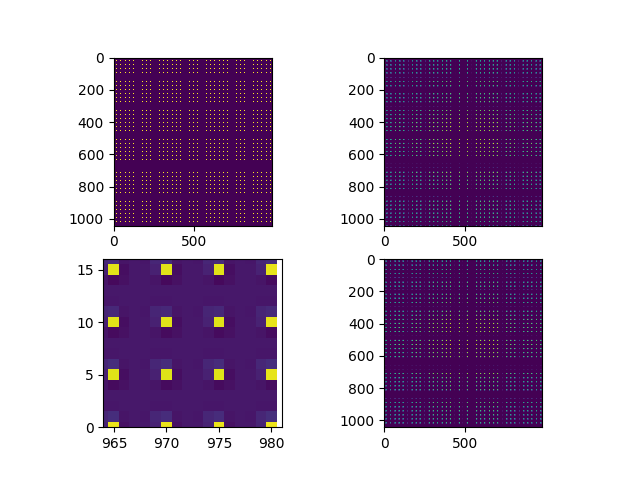

In [157]:
dummy_image = numpy.zeros(mask.shape, dtype="float32")
dummy_image[::5,::5] = 1
#dummy_image[mask] = -1
csr = csr_matrix(pre_csr)
dummy_blurred = csr.T.dot(dummy_image.ravel()).reshape(mask.shape)
fix, ax = subplots(2,2)
ax[0,0].imshow(dummy_image)
ax[0,1].imshow(csr.dot(dummy_image.ravel()).reshape(mask.shape))
ax[1,1].imshow(csr.T.dot(dummy_image.ravel()).reshape(mask.shape))


In [158]:
ax[0,0].set_xlim(964,981)
ax[0,0].set_ylim(0,16)
ax[0,1].set_xlim(964,981)
ax[0,1].set_ylim(0,16)
ax[1,1].set_xlim(964,981)
ax[1,1].set_ylim(0,16)

(0, 16)

In [150]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [159]:
def f(damp):
    res = linalg.lsmr(csr.T, dummy_image.ravel(), damp=damp, atol=1e-10, btol=1e-08, maxiter=1000, x0=dummy_image.ravel())
    restored = res[0].reshape(mask.shape)
    ax[1,0].imshow(restored)
    ax[1,0].set_xlim(964,981)
    ax[1,0].set_ylim(0,16)


interactive_plot = widgets.interactive(f, damp=(0, 2.0))
display(interactive_plot)

interactive(children=(FloatSlider(value=1.0, description='damp', max=2.0), Output()), _dom_classes=('widget-interact',))

@article{doi:10.1137/10079687X,
author = {David Chin-Lung Fong and Michael Saunders},
title = {LSMR: An Iterative Algorithm for Sparse Least-Squares Problems},
journal = {SIAM Journal on Scientific Computing},
volume = {33},
number = {5},
pages = {2950-2971},
year = {2011},
doi = {10.1137/10079687X},

URL = { 
        https://doi.org/10.1137/10079687X
    
},
eprint = { 
        https://doi.org/10.1137/10079687X
    
}

}

In [107]:
numpy.zeros(0)

array([], dtype=float64)